In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

## Let's clean the data

In [2]:
df = pd.read_csv('data/all_transactions.csv')
df.head()

,disclosure_year,disclosure_date,transaction_date,owner,ticker,asset_description,type,amount,representative,district,ptr_link,cap_gains_over_200_usd
0,2021,10/04/2021,2021-09-27,joint,BP,BP plc,purchase,"$1,001 - $15,000",Hon. Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False
1,2021,10/04/2021,2021-09-13,joint,XOM,Exxon Mobil Corporation,purchase,"$1,001 - $15,000",Hon. Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False
2,2021,10/04/2021,2021-09-10,joint,ILPT,Industrial Logistics Properties Trust - Common...,purchase,"$15,001 - $50,000",Hon. Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False
3,2021,10/04/2021,2021-09-28,joint,PM,Phillip Morris International Inc,purchase,"$15,001 - $50,000",Hon. Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False
4,2021,10/04/2021,2021-09-17,self,BLK,BlackRock Inc,sale_partial,"$1,001 - $15,000",Hon. Alan S. Lowenthal,CA47,https://disclosures-clerk.house.gov/public_dis...,False


Look at the types of the columns to see which ones may need to have their types changed.

In [3]:
df.dtypes

disclosure_year            int64
disclosure_date           object
transaction_date          object
owner                     object
ticker                    object
asset_description         object
type                      object
amount                    object
representative            object
district                  object
ptr_link                  object
cap_gains_over_200_usd      bool
dtype: object

```disclosure_data``` and ```transaction_date``` can be represented in date time, but they are normal objects right now. 

In [4]:
# need to have errors = 'coerce', so some weird data gets set to np.nan
df['disclosure_date'] = pd.to_datetime(df['disclosure_date'], errors = 'coerce')
df['transaction_date'] = pd.to_datetime(df['transaction_date'], errors = 'coerce')
df.dtypes

disclosure_year                    int64
disclosure_date           datetime64[ns]
transaction_date          datetime64[ns]
owner                             object
ticker                            object
asset_description                 object
type                              object
amount                            object
representative                    object
district                          object
ptr_link                          object
cap_gains_over_200_usd              bool
dtype: object

Let's clean the 'Hon. ' out of every rep's name so it becomes easier to read.

In [5]:
# regex=False to get rid of regex depracated warning
df['representative'] = df['representative'].str.replace('Hon. ', '', regex=False)

Let's create a `state` column so we can do groupby state if we need to in the future.

In [6]:
df['state'] = df['district'].str[:2]
df.head()

,disclosure_year,disclosure_date,transaction_date,owner,ticker,asset_description,type,amount,representative,district,ptr_link,cap_gains_over_200_usd,state
0,2021,2021-10-04,2021-09-27,joint,BP,BP plc,purchase,"$1,001 - $15,000",Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,NC
1,2021,2021-10-04,2021-09-13,joint,XOM,Exxon Mobil Corporation,purchase,"$1,001 - $15,000",Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,NC
2,2021,2021-10-04,2021-09-10,joint,ILPT,Industrial Logistics Properties Trust - Common...,purchase,"$15,001 - $50,000",Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,NC
3,2021,2021-10-04,2021-09-28,joint,PM,Phillip Morris International Inc,purchase,"$15,001 - $50,000",Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,NC
4,2021,2021-10-04,2021-09-17,self,BLK,BlackRock Inc,sale_partial,"$1,001 - $15,000",Alan S. Lowenthal,CA47,https://disclosures-clerk.house.gov/public_dis...,False,CA


Now let's deal with the ranges in the ```amount``` column. The ranges are an issue for 2 reasons:

* We can't do math with a range
* It's harder to read

So let's create a new column, ```amount_cleaned```, that consists of the mean of the range given in ```amount```. 

And for values without a range, e.g. '$1,001 -', we'll deal with those after we fill in the ranges with averages.

In [7]:
mapped_values = {
    '$1,001 - $15,000':8_000.5,
    '$15,001 - $50,000':32_500.5,
    '$50,001 - $100,000':75_000.5,
    '$100,001 - $250,000':175_000.5,

    # place holder so we can calculate values by filling in average
    '$1,001 -':-99,

    '$250,001 - $500,000':375_000.5,
    '$500,001 - $1,000,000':375_000.5,
    '$1,000,001 - $5,000,000':3_000_000.5,

    # place holder so we can calculate values by filling in average
    '$1,000,000 +':-100,

    '$5,000,001 - $25,000,000':15_000_000.5,
    '$1,000 - $15,000':8_000,
    '$15,000 - $50,000':32_000,

    # we aren't giving 50,000,000+ a placeholder here, because we think
    # 50,000,000+ is already too much so let's just keep the average as is.
    '$50,000,000 +':50_000_000,
    '$1,000,000 - $5,000,000':3_000_000,
}
df['amount_cleaned'] = df['amount'].replace(mapped_values)

Now let's deal with the non-ranges.

Let's find the average of ```amount_cleaned``` column when values are above $1,001 and $1,000,000 seperately.

In [8]:
avg_above_1001 = round(df.loc[df['amount_cleaned'] >= 1_001]['amount_cleaned'].mean(), 2)
avg_above_1_mil = round(df.loc[df['amount_cleaned'] >= 1_000_000]['amount_cleaned'].mean(), 2)

avg_above_1001, avg_above_1_mil

(53267.76, 6163265.79)

In [9]:
# replace -99, which maps to '$1,001 -' in 'amounts' with avg_above_1001
df['amount_cleaned'] = df['amount_cleaned'].replace({-99: avg_above_1001})

# replace -100, which maps to '$1,001 -' in 'amounts' with avg_above_1_mil
df['amount_cleaned'] = df['amount_cleaned'].replace({-100: avg_above_1_mil})

# let's make sure the -99 and -100 values are gone!
df['amount_cleaned'].value_counts()

8000.50        10008
32500.50        2237
75000.50         718
175000.50        545
375000.50        368
53267.76         242
3000000.50        38
6163265.79        28
15000000.50        9
8000.00            4
32000.00           3
3000000.00         1
50000000.00        1
Name: amount_cleaned, dtype: int64

In [10]:
# let's make sure our newly added column is of type float
df.dtypes

disclosure_year                    int64
disclosure_date           datetime64[ns]
transaction_date          datetime64[ns]
owner                             object
ticker                            object
asset_description                 object
type                              object
amount                            object
representative                    object
district                          object
ptr_link                          object
cap_gains_over_200_usd              bool
state                             object
amount_cleaned                   float64
dtype: object

In [11]:
# df.to_csv('data/cleaned_all_transactions.csv')

## EDA Time

### **Univariate Analysis** - We need to look at the distributions of relevant columns separately by using DataFrame operations and drawing appropriate plots.

Note: ```value_counts()``` will help us understand the values of a column by showing us how many times each entry occurs.

Let's explore the ``disclosure_year`` columm first

In [12]:
# call .value_counts on 'disclosure_year'
df['disclosure_year'].value_counts()

2020    7379
2021    5520
2022    1303
Name: disclosure_year, dtype: int64

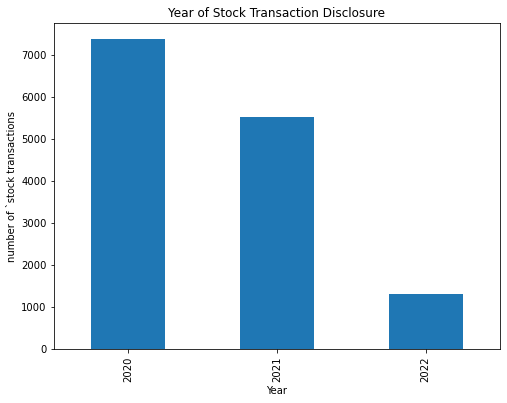

In [13]:
# first call .value_counts(), then .plot(), so graph is easier to read
df['disclosure_year'].value_counts().plot(kind = 'bar', \
    title = 'Year of Stock Transaction Disclosure', \
    xlabel = 'Year', ylabel = 'number of `stock transactions', figsize=(8,6));

Clearly **2020** was the most popular year in this data set. This doesn't mean that the reps just traded more in 2020 than in 2021 or 2022, they probably just have not disclosed trades from those two years yet.

Now let's look at the ```ticker``` column. There are too many individiual tickers (abbreviations used to uniquely identify shares of a particular stock), so we will only look at the top 20.

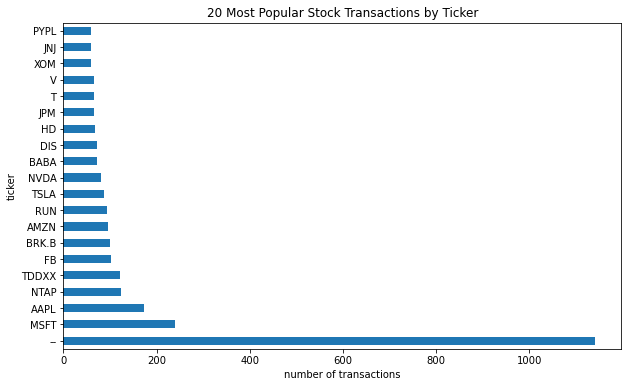

In [14]:
df['ticker'].value_counts()[:20].plot(kind = 'barh', figsize=(10,6))
plt.title('20 Most Popular Stock Transactions by Ticker')
plt.ylabel('ticker')
plt.xlabel('number of transactions')
plt.show()

Clearly, the most popular stock trades are in tech:
* Microsoft
* Apple
* NetApp
* FaceBook (Meta)
* Amazon
* Tesla
* and so on...

But there is even a Fed Fund:
*  BLF FedFund (TDDXX)


**Surprised rich people are investing in fed funds?**

**Hey, maybe the old people in the House of Representatives *really do care***
**about their retirement funds!**


The biggest surprise, however, is the most popular ticker, '--', which isn't even a stock. What is '--'? Let's clean that up and convert to `np.nan`

In [15]:
df['ticker'] = df['ticker'].replace({'--': np.nan})

Let's make sure the `--` characters are gone.

In [16]:
df[df['ticker'] == '--']

,disclosure_year,disclosure_date,transaction_date,owner,ticker,asset_description,type,amount,representative,district,ptr_link,cap_gains_over_200_usd,state,amount_cleaned


Now let's look at the ```amount_cleaned``` column, to see how much of that 💰💸🤑 reps bring in.

In [17]:
df['amount_cleaned'].value_counts()

8000.50        10008
32500.50        2237
75000.50         718
175000.50        545
375000.50        368
53267.76         242
3000000.50        38
6163265.79        28
15000000.50        9
8000.00            4
32000.00           3
3000000.00         1
50000000.00        1
Name: amount_cleaned, dtype: int64

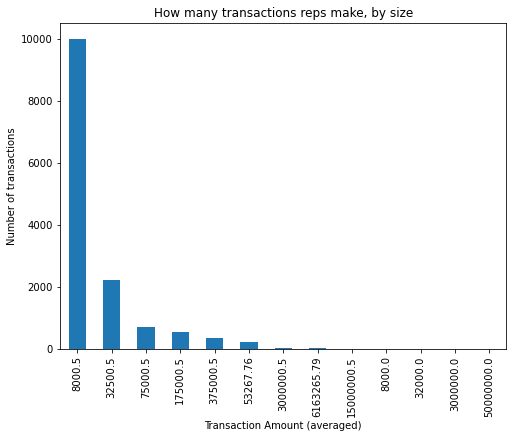

In [18]:
# first call .value_counts(), then .plot(), so graph is easier to read
df['amount_cleaned'].value_counts().plot(kind = 'bar', \
    title = 'How many transactions reps make, by size', ylabel = 'Number of transactions', \
    xlabel = 'Transaction Amount (averaged)', figsize=(8,6));

Wow! An overwhelming majority of stock trades are averaged out to 8k, that we cannot even estimate how many transactions are done for any transaction above $53267.76

### **Bivariate Analysis** - We need to look at the statistics of pairs of columns to identify possible associations. 

We want to see whether reps have many counts of capital gains of over $200 or few. Let's find that out by grouping ```amount_cleaned``` and ```cap_gains_over_200_usd```.

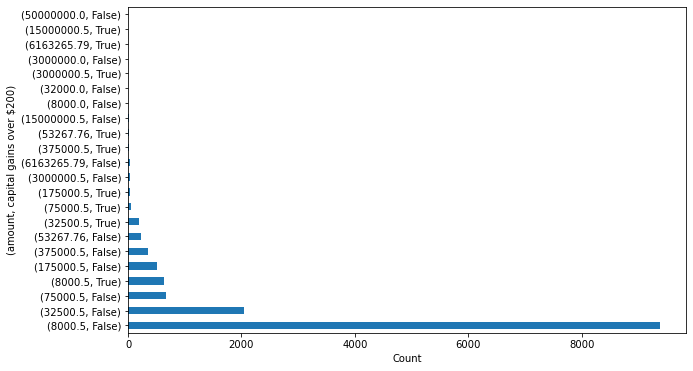

In [19]:
df[['amount_cleaned', 'cap_gains_over_200_usd']].value_counts().plot(kind = 'barh', figsize=(10,6))
plt.xlabel("Count")
plt.ylabel("(amount, capital gains over $200)")
plt.show()

Clearly, the three most popular categories of trade are:

* $8,000.5
* $32,500.5
* $75,000.5

And all of the trade categories have less than $200 in capital gains.

Reps need to realize they ain't so good at trading huh 🤣

## Interesting Aggregate Statistics / Pivots

**Let's find out if there are any reps with a 100% `cap_gains_over_200_usd` proportion score.**

In [20]:
(
    df.pivot_table(index = 'representative', values = 'cap_gains_over_200_usd')
    .sort_values(by='cap_gains_over_200_usd', ascending=False)
)

,cap_gains_over_200_usd
representative,
Patrick T. McHenry,1.000000
Mr. TJ John (Tj) Cox,1.000000
Tim Burchett,1.000000
Mr. Peter Meijer,0.902256
Bradley S. Schneider,0.777778
...,...
Harold Dallas Rogers,0.000000
Harley E. Rouda,0.000000
Gus M. Bilirakis,0.000000


It looks like Reps. Patrick T. McHenry, Mr. TJ John (Tj) Cox, and Tim Burchett are pros, with a 100% ```cap_gains_over_200_usd``` proportion score. But, are they really?"

In [21]:
df[
    (df['representative'] == 'Patrick T. McHenry') |
    (df['representative'] == 'Mr. TJ John (Tj) Cox') |
    (df['representative'] == 'Tim Burchett')
    ]

,disclosure_year,disclosure_date,transaction_date,owner,ticker,asset_description,type,amount,representative,district,ptr_link,cap_gains_over_200_usd,state,amount_cleaned
56,2020,2020-09-22,2020-08-17,NaN,NaN,Metallic Minerals Corp.,sale_partial,"$100,001 - $250,000",Mr. TJ John (Tj) Cox,CA21,https://disclosures-clerk.house.gov/public_dis...,True,CA,175000.5
10854,2021,2021-01-10,2020-11-19,NaN,D,Sale of shares in Dominion Energy Inc.,sale_full,"$15,001 - $50,000",Patrick T. McHenry,NC10,https://disclosures-clerk.house.gov/public_dis...,True,NC,32500.5
13381,2020,2020-02-26,2020-02-12,NaN,DENN,Denny's Corporation,sale_full,"$1,001 - $15,000",Tim Burchett,TN02,https://disclosures-clerk.house.gov/public_dis...,True,TN,8000.5


Upon further review, it seems that they each have only traded once so we don't have enough data to conclude that they are really pros at stock trading. 

**Which state has the highest average number of trades that result in capital gains over $200?**

In [22]:
(
    df.pivot_table(index = 'state', values = 'cap_gains_over_200_usd')
    .sort_values(by = 'cap_gains_over_200_usd', ascending=False)
    .head()
)

,cap_gains_over_200_usd
state,
MI,0.772871
SC,0.379310
NY,0.280702
ID,0.222222
LA,0.222222


Michigan! With a pretty mind blowing result of 77% 🤯

**Note:** The first that may come to mind is that Michigan may have had a high ```cap_gains_over_200_usd``` value for relatively small trades, in the $8000.5 category, and low numbers in the rest. This would have induced Simpson's paradox. But as shown below, we checked with another pivot table, and it is really the case that Michigan has high ```cap_gains_over_200_usd``` values for *all* amount categories. 

Let's look at `cap_gains_over_200_usd` values indexed by the stock transaction amount itself, for each type of exchange.

In [23]:
df.pivot_table(index='amount_cleaned', values='cap_gains_over_200_usd', columns='type')

type,exchange,purchase,sale_full,sale_partial
amount_cleaned,,,,
8000.00,NaN,NaN,0.000000,0.000000
8000.50,0.0,0.001744,0.101849,0.184381
32000.00,NaN,NaN,0.000000,0.000000
32500.50,0.0,0.001589,0.188703,0.230337
53267.76,0.0,0.000000,0.272727,0.103175
75000.50,0.0,0.007712,0.131148,0.311475
175000.50,0.0,0.000000,0.105505,0.325000
375000.50,0.0,0.000000,0.068323,0.433333
3000000.00,NaN,NaN,0.000000,NaN


**Now, let's dive into another interesting question:** Is there a difference in trade disclosure period for different stock transaction `amount`? In other words, do reps tend to delay disclosing their trades information if they are investing a lot? Let's find out.

First, let's examine how long it takes for reps to disclose their trade

In [33]:
# assign a new column 'non_disclosure_period(days)' to be difference of 'disclosure_date' and 'transaction_date'
df['non_disclosure_period(days)'] = (df['disclosure_date'] - df['transaction_date']).dt.days
df.head()

,disclosure_year,disclosure_date,transaction_date,owner,ticker,asset_description,type,amount,representative,district,ptr_link,cap_gains_over_200_usd,state,amount_cleaned,non_disclosure_period(days)
0,2021,2021-10-04,2021-09-27,joint,BP,BP plc,purchase,"$1,001 - $15,000",Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,NC,8000.5,7.0
1,2021,2021-10-04,2021-09-13,joint,XOM,Exxon Mobil Corporation,purchase,"$1,001 - $15,000",Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,NC,8000.5,21.0
2,2021,2021-10-04,2021-09-10,joint,ILPT,Industrial Logistics Properties Trust - Common...,purchase,"$15,001 - $50,000",Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,NC,32500.5,24.0
3,2021,2021-10-04,2021-09-28,joint,PM,Phillip Morris International Inc,purchase,"$15,001 - $50,000",Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,NC,32500.5,6.0
4,2021,2021-10-04,2021-09-17,self,BLK,BlackRock Inc,sale_partial,"$1,001 - $15,000",Alan S. Lowenthal,CA47,https://disclosures-clerk.house.gov/public_dis...,False,CA,8000.5,17.0


In [35]:
df['non_disclosure_period(days)'].median()

28.0

Looks like most transactions are disclosed within a month! Let's now find out whether there is a correlation between stock transaction `amount` and `non_disclosure_period(days)`

But, firstly, we need to do a bit of cleaning.
There are 13 transactions where non disclosure days are negative. We will exclude those. There is one transaction where the non disclosure period is 3355 days! As our median is 28, we will exclude this as well because it is not relevant to our question and we don't want it to sway our conclusion. 

In [39]:
df[df['non_disclosure_period(days)'] < 0].shape[0]

13

In [42]:
df[(df['non_disclosure_period(days)'] > 2000)].shape[0]

1

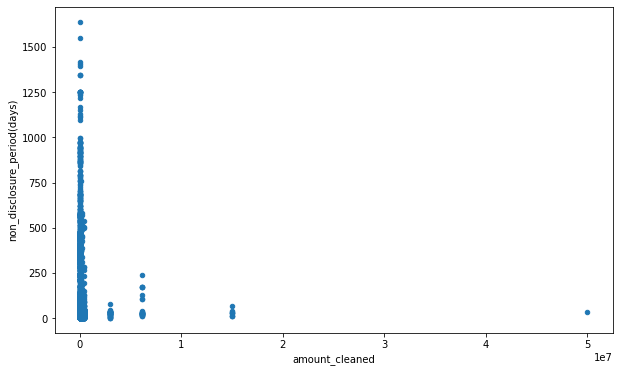

In [61]:
relevant_non_disclosure_periods = df[(df['non_disclosure_period(days)'] < 2000) & (df['non_disclosure_period(days)'] > 0)][['amount_cleaned', 'non_disclosure_period(days)']]
relevant_non_disclosure_periods.plot(kind='scatter', x='amount_cleaned', y = 'non_disclosure_period(days)', figsize=(10,6));

As most of our data is seems to be less than trade transaction amount of 2 million, let's zoom in on its left to see if we notice anything.

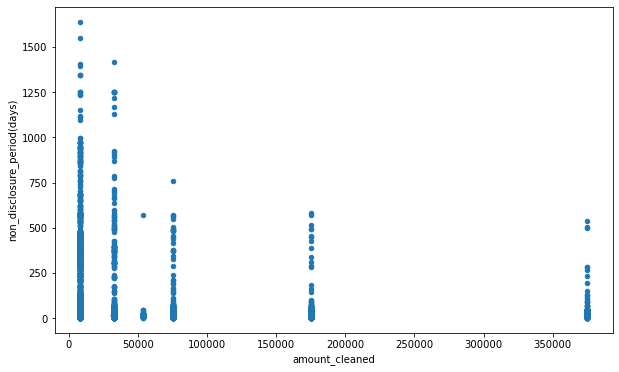

In [60]:
closer_look = relevant_non_disclosure_periods[relevant_non_disclosure_periods['amount_cleaned'] < 2_000_000]
closer_look.plot(kind='scatter', x='amount_cleaned', y = 'non_disclosure_period(days)', figsize=(10,6));

We notice that there doesn't seem to be much relationship between transaction amount and the non disclosure period. Our hypothesis was that reps that have invested more in trades delay disclosing it, but here we see a decline, where, if the transaction was high, they seem to be disclosing it sooner than if the transaction was low. We will need to investigate if this is really the case later. 

Let's see what trade took the longest time to be disclosed.

In [63]:
 #atharva's : 
(
    df.sort_values(by = 'non_disclosure_period(days)', ascending=False)
    [['representative', 'non_disclosure_period(days)', 'amount_cleaned', 'ticker', 'district']]
    .head(3)
)


,representative,non_disclosure_period(days),amount_cleaned,ticker,district
9737,Tom Malinowski,3355.0,8000.5,BLFSD,NJ07
10449,Thomas Suozzi,1640.0,8000.5,SUP,NY03
10430,Thomas Suozzi,1548.0,8000.5,CAT,NY03


Wow! 3355 is nearly 10 years! Does that seem sussy...